In [130]:
import torch
import torch.nn as nn

In [131]:
class Layer:
    def __init__(self, D_in, D_out, activation_type="relu"):
        self.D_in = D_in
        self.D_out = D_out
        self.activation_type = activation_type
        
        # Initialize weights with proper scaling (Xavier initialization)
        self.W = torch.randn((D_in, D_out)) * torch.sqrt(torch.tensor(2.0 / D_in))
        self.b = torch.zeros(D_out)
        
        # Enable gradient tracking
        self.W.requires_grad = True
        self.b.requires_grad = True
        
        # Set activation function
        if activation_type == "relu":
            self.activation = nn.ReLU()
        elif activation_type == "tanh":
            self.activation = nn.Tanh()
        elif activation_type == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
    
    def forward(self, X):
        """Forward pass through the layer"""
        z = X @ self.W + self.b
        if self.activation is not None:
            a = self.activation(z)
        else:
            a = z
        return a, z  # Return both activated and raw outputs
    
    def parameters(self):
        """Return list of parameters for easy access"""
        return [self.W, self.b]

In [132]:
class Network:
    def __init__(self, layer_dims, activation_types=None, optimizer_type=None):
        """
        Args:
            layer_dims: list of dimensions [input, hidden1, hidden2, ..., output]
            activation_types: list of activation types for each layer
            optimizer_type: "SGD", "Adam", or None
        """
        self.layers = []
        self.layer_dims = layer_dims
        self.optimizer_type = optimizer_type
        
        if activation_types is None:
            activation_types = ["relu"] * (len(layer_dims) - 2) + ["none"]

        # Create layers first
        for i in range(len(layer_dims) - 1):
            layer = Layer(layer_dims[i], layer_dims[i+1], activation_types[i])
            self.layers.append(layer)
        
        if optimizer_type == "Adam":
            self.mt = [torch.zeros_like(p) for p in self.parameters()]
            self.vt = [torch.zeros_like(p) for p in self.parameters()]
            self.t = 0
        elif optimizer_type == "SGD":
            self.velocity = [torch.zeros_like(p) for p in self.parameters()]

    def forward(self, X):
        """Forward pass through entire network"""
        a = X
        for layer in self.layers:
            a, _ = layer.forward(a)
        return a

    def parameters(self):
        """Get all parameters from all layers"""
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

    def train_epoch(self, X, y, learning_rate, momentum=0.9):
        """Train for one epoch"""
        # Forward pass
        predictions = self.forward(X)

        # Compute loss
        loss = torch.mean((predictions - y) ** 2)

        # Backward pass
        loss.backward()

        # Update parameters
        if self.optimizer_type is None:
            # Standard SGD
            with torch.no_grad():
                for param in self.parameters():
                    param -= learning_rate * param.grad
                    
        elif self.optimizer_type == "SGD":
            with torch.no_grad():
                for i, param in enumerate(self.parameters()):
                    self.velocity[i] = momentum * self.velocity[i] - learning_rate * param.grad
                    param += self.velocity[i]
                    
        elif self.optimizer_type == "Adam":
            beta1 = 0.9 
            beta2 = 0.999
            epsilon = 1e-8
            
            self.t += 1  
            
            with torch.no_grad():
                for i, param in enumerate(self.parameters()):
                    self.mt[i] = beta1 * self.mt[i] + (1 - beta1) * param.grad
                    self.vt[i] = beta2 * self.vt[i] + (1 - beta2) * (param.grad ** 2)
                    mt_hat = self.mt[i] / (1 - beta1 ** self.t)
                    vt_hat = self.vt[i] / (1 - beta2 ** self.t)
                    param -= learning_rate * mt_hat / (torch.sqrt(vt_hat + epsilon))

        # Zero gradients
        for param in self.parameters():
            if param.grad is not None:
                param.grad.zero_()

        return loss.item()

In [133]:
def train_network(model, X, y, epochs, learning_rate, verbose=True):
    """Train the network and return loss history"""
    losses = []
    
    for epoch in range(epochs):
        loss = model.train_epoch(X, y, learning_rate)
        losses.append(loss)
        
        if verbose and epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs}: Loss = {loss:.6f}")
    
    print(f"Final Loss: {losses[-1]:.6f}")
    return losses

Epoch 0/2000: Loss = 28.191404
Epoch 200/2000: Loss = 0.201275
Epoch 400/2000: Loss = 0.089132
Epoch 600/2000: Loss = 0.102366
Epoch 800/2000: Loss = 0.031640
Epoch 1000/2000: Loss = 0.024775
Epoch 1200/2000: Loss = 0.024886
Epoch 1400/2000: Loss = 0.018260
Epoch 1600/2000: Loss = 0.011929
Epoch 1800/2000: Loss = 0.006484
Final Loss: 0.004653


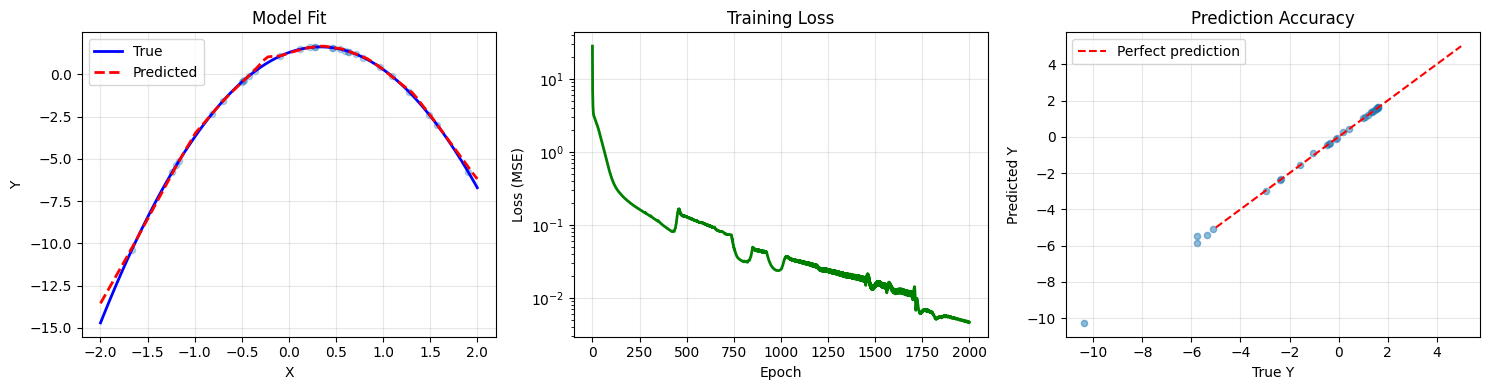

In [134]:
# ==================== DATA SETUP ====================
N = 30
D_in = 1
D_out = 1

X = torch.randn(N, D_in)
true_w1 = torch.tensor([[-3.0]])
true_w2 = torch.tensor([[2.0]])
true_b = torch.tensor(1.3)
y_true = (X**2) @ true_w1 + X @ true_w2 + true_b + torch.randn(N, D_out) * 0.01

# ==================== MODEL SETUP ====================
# Define architecture: input -> hidden -> output
layer_dims = [1, 64, 32, 1]  # 1 input, 64 hidden, 32 hidden, 1 output
activation_types = ["relu", "relu", "none"]  # activation for each layer

model = Network(layer_dims, activation_types)

# ==================== TRAINING ====================
learning_rate = 0.01
epochs = 2000
losses = train_network(model, X, y_true, epochs, learning_rate)

# ==================== VISUALIZATION ====================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Predicted vs True
X_plot = torch.linspace(-2, 2, 100).reshape(-1, 1)
y_pred_plot = model.forward(X_plot).detach()
y_true_plot = (X_plot**2) @ true_w1 + X_plot @ true_w2 + true_b

axes[0].plot(X_plot.numpy(), y_true_plot.numpy(), 'b-', linewidth=2, label='True')
axes[0].plot(X_plot.numpy(), y_pred_plot.numpy(), 'r--', linewidth=2, label='Predicted')
axes[0].scatter(X.numpy(), y_true.numpy(), alpha=0.3, s=20)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Model Fit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss curve
axes[1].plot(losses, linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title('Training Loss')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (scatter)
y_pred_all = model.forward(X).detach()
axes[2].scatter(y_true.numpy(), y_pred_all.numpy(), alpha=0.5, s=20)
axes[2].plot([-5, 5], [-5, 5], 'r--', label='Perfect prediction')
axes[2].set_xlabel('True Y')
axes[2].set_ylabel('Predicted Y')
axes[2].set_title('Prediction Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Training with optimizer: Standard SGD
Final Loss: 0.016369
Final Loss: 0.016369

Training with optimizer: SGD
Final Loss: 0.000172
Final Loss: 0.000172

Training with optimizer: Adam
Final Loss: 0.000258
Final Loss: 0.000258


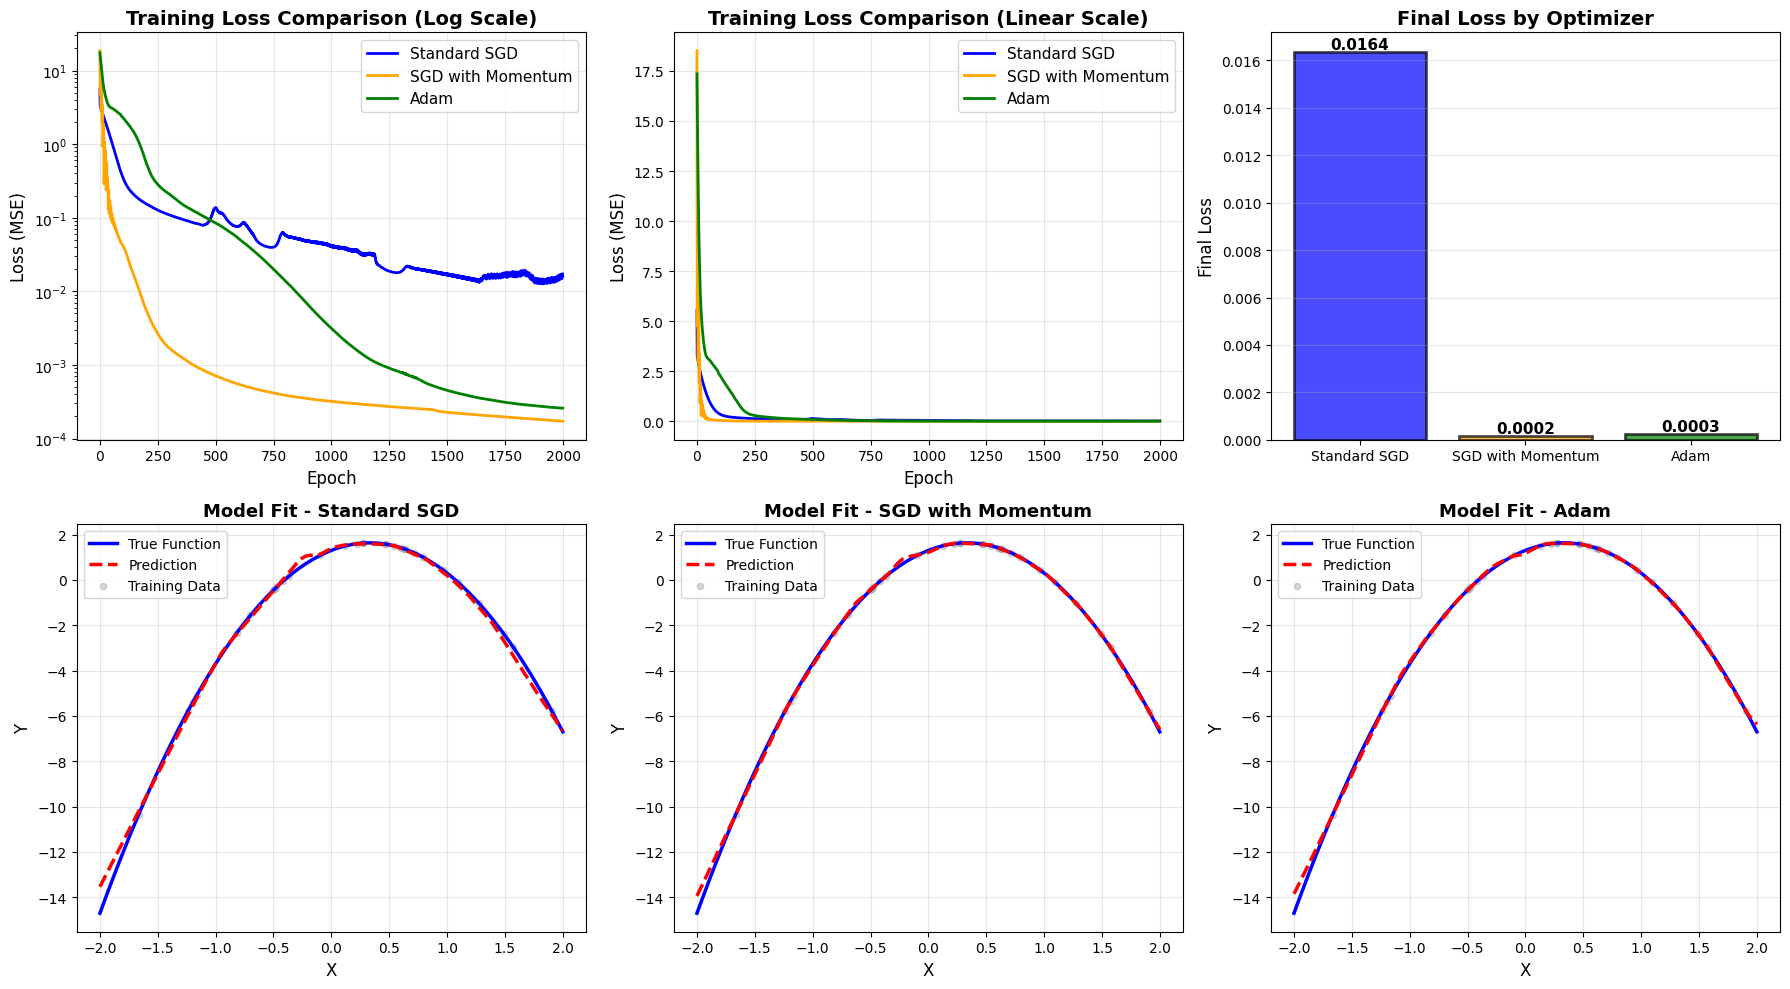


OPTIMIZER COMPARISON SUMMARY

Optimizer            Final Loss      Loss Reduction     Convergence    
----------------------------------------------------------------------
Standard SGD         0.016369        99.71%             9 epochs       
SGD with Momentum    0.000172        100.00%            9 epochs       
Adam                 0.000258        100.00%            73 epochs      



In [135]:
import matplotlib.pyplot as plt

# ==================== TRAIN WITH DIFFERENT OPTIMIZERS ====================

optimizers = [None, "SGD", "Adam"]
all_losses = {}
all_models = {}

for opt_type in optimizers:
    print(f"\n{'='*50}")
    print(f"Training with optimizer: {opt_type if opt_type else 'Standard SGD'}")
    print(f"{'='*50}")
    
    # Create model with specific optimizer
    model = Network(layer_dims, activation_types, optimizer_type=opt_type)
    all_models[opt_type] = model
    
    # Adjust learning rate based on optimizer
    if opt_type == "Adam":
        learning_rate = 0.001  # Adam uses lower learning rate
    else:
        learning_rate = 0.01
    
    # Train
    losses = train_network(model, X, y_true, epochs, learning_rate, verbose=False)
    all_losses[opt_type] = losses
    
    print(f"Final Loss: {losses[-1]:.6f}")

# ==================== VISUALIZATION: COMPARE OPTIMIZERS ====================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Loss Curves Comparison
ax = axes[0, 0]
colors = {'None': 'blue', 'SGD': 'orange', 'Adam': 'green'}
labels_map = {None: 'Standard SGD', 'SGD': 'SGD with Momentum', 'Adam': 'Adam'}

for opt_type in optimizers:
    label = labels_map[opt_type]
    color = colors[list(colors.keys())[optimizers.index(opt_type)]]
    ax.plot(all_losses[opt_type], linewidth=2, label=label, color=color)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training Loss Comparison (Log Scale)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Linear Scale Loss Comparison
ax = axes[0, 1]
for opt_type in optimizers:
    label = labels_map[opt_type]
    color = colors[list(colors.keys())[optimizers.index(opt_type)]]
    ax.plot(all_losses[opt_type], linewidth=2, label=label, color=color)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training Loss Comparison (Linear Scale)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Final Loss Comparison (Bar Chart)
ax = axes[0, 2]
final_losses = [all_losses[opt_type][-1] for opt_type in optimizers]
optimizer_names = [labels_map[opt_type] for opt_type in optimizers]
colors_list = [colors[list(colors.keys())[i]] for i in range(len(optimizers))]

bars = ax.bar(optimizer_names, final_losses, color=colors_list, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Final Loss', fontsize=12)
ax.set_title('Final Loss by Optimizer', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{loss:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# ==================== PREDICTION PLOTS FOR ALL OPTIMIZERS ====================

# Plot 4, 5, 6: Predictions for each optimizer
X_plot = torch.linspace(-2, 2, 100).reshape(-1, 1)
y_true_plot = (X_plot**2) @ true_w1 + X_plot @ true_w2 + true_b

for idx, opt_type in enumerate(optimizers):
    ax = axes[1, idx]
    model = all_models[opt_type]
    y_pred_plot = model.forward(X_plot).detach()
    
    # Plot true function
    ax.plot(X_plot.numpy(), y_true_plot.numpy(), 'b-', linewidth=2.5, label='True Function')
    
    # Plot predicted function
    ax.plot(X_plot.numpy(), y_pred_plot.numpy(), 'r--', linewidth=2.5, label='Prediction')
    
    # Scatter actual data points
    ax.scatter(X.numpy(), y_true.numpy(), alpha=0.3, s=20, color='gray', label='Training Data')
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'Model Fit - {labels_map[opt_type]}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== SUMMARY STATISTICS ====================

print("\n" + "="*60)
print("OPTIMIZER COMPARISON SUMMARY")
print("="*60)

summary_data = {
    'Optimizer': [],
    'Final Loss': [],
    'Loss Reduction (%)': [],
    'Convergence Speed': []
}

initial_loss = all_losses[None][0]

for opt_type in optimizers:
    losses = all_losses[opt_type]
    final_loss = losses[-1]
    reduction = ((initial_loss - final_loss) / initial_loss) * 100
    
    # Convergence speed: epochs to reach 50% of initial loss
    target_loss = initial_loss * 0.5
    convergence = next((i for i, l in enumerate(losses) if l <= target_loss), epochs)
    
    summary_data['Optimizer'].append(labels_map[opt_type])
    summary_data['Final Loss'].append(f"{final_loss:.6f}")
    summary_data['Loss Reduction (%)'].append(f"{reduction:.2f}%")
    summary_data['Convergence Speed'].append(f"{convergence} epochs")

# Print table
print(f"\n{'Optimizer':<20} {'Final Loss':<15} {'Loss Reduction':<18} {'Convergence':<15}")
print("-" * 70)
for i in range(len(summary_data['Optimizer'])):
    print(f"{summary_data['Optimizer'][i]:<20} {summary_data['Final Loss'][i]:<15} {summary_data['Loss Reduction (%)'][i]:<18} {summary_data['Convergence Speed'][i]:<15}")

print("\n" + "="*60)

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10 (digits 0-9)


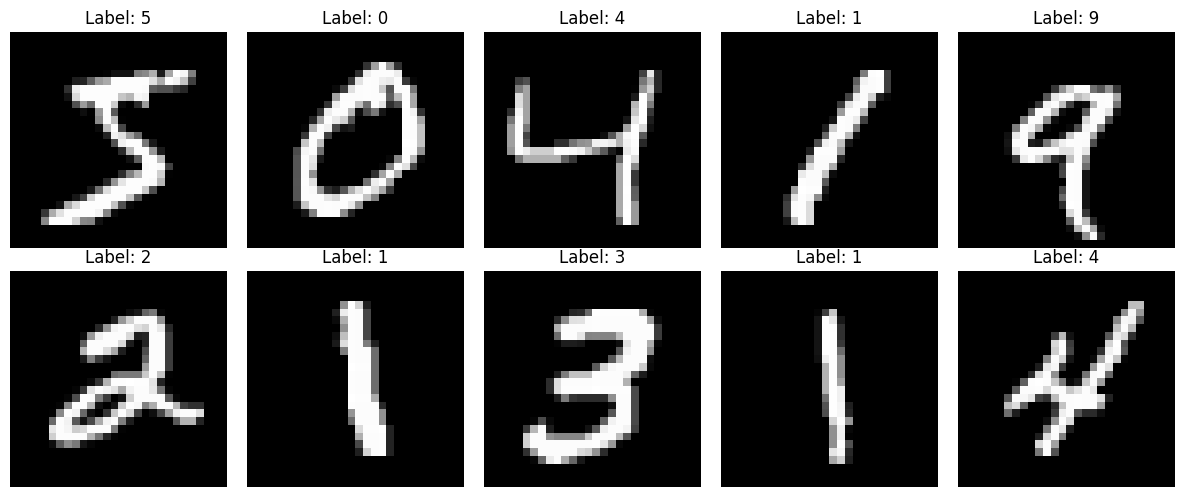


Flattened input size: 784
Output classes: 10


In [136]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ==================== LOAD MNIST DATASET ====================

# Define transforms (normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: 10 (digits 0-9)")

# ==================== VISUALIZE SAMPLES ====================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# ==================== PREPARE FOR NETWORK ====================

# Flatten images for our fully connected network
# MNIST images are 28x28 = 784 pixels
input_size = 28 * 28
num_classes = 10

print(f"\nFlattened input size: {input_size}")
print(f"Output classes: {num_classes}")

Epoch 1/10: Loss = 0.047930
Epoch 2/10: Loss = 0.015784
Epoch 3/10: Loss = 0.013460
Epoch 4/10: Loss = 0.012089
Epoch 5/10: Loss = 0.011549
Epoch 6/10: Loss = 0.011249
Epoch 7/10: Loss = 0.010777
Epoch 8/10: Loss = 0.010809
Epoch 9/10: Loss = 0.010492
Epoch 10/10: Loss = 0.010514


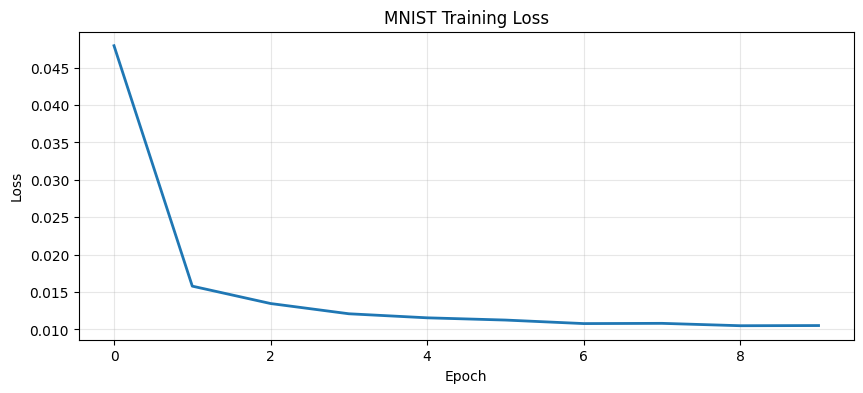

In [137]:
# ==================== NEW MODEL FOR MNIST ====================

# Update architecture for MNIST
layer_dims = [784, 128, 64, 32, 10]  # 784 input, 3 hidden layers, 10 output
activation_types = ["relu", "relu", "relu", "none"]
optimizer_type = "Adam"
model = Network(layer_dims, activation_types,optimizer_type)

# ==================== TRAINING ON MNIST ====================

def train_mnist_epoch(model, train_loader, learning_rate):
    """Train for one epoch on MNIST"""
    total_loss = 0
    
    for images, labels in train_loader:
        # Flatten images: (batch_size, 1, 28, 28) -> (batch_size, 784)
        images = images.reshape(-1, 28 * 28)
        
        # Convert labels to one-hot encoding
        labels_one_hot = torch.zeros(labels.shape[0], 10)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
        
        # Train on this batch
        loss = model.train_epoch(images, labels_one_hot, learning_rate)
        total_loss += loss
    
    return total_loss / len(train_loader)

# Train
learning_rate = 0.01
epochs = 10
losses = []

for epoch in range(epochs):
    loss = train_mnist_epoch(model, train_loader, learning_rate)
    losses.append(loss)
    print(f"Epoch {epoch+1}/{epochs}: Loss = {loss:.6f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MNIST Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [138]:
total_test = 0
correct_prediction = 0

for images,labels in test_loader:
    images = images.reshape(-1,28*28)
    prediction = model.forward(images)
    prediction = torch.argmax(prediction,dim =1)
    correct_prediction += torch.sum(prediction == labels)
    total_test += labels.shape[0]
accuracy = correct_prediction/total_test *100
print(f"Accuracy: {accuracy}")

Accuracy: 94.05999755859375
